## Summary of the Geolocation Bias Corrections

+ Distribution of the range delay time series using `boxenplot`
+ Overall RMSE in Table

Link: https://seaborn.pydata.org/generated/seaborn.boxenplot.html

In [1]:
%matplotlib inline
import os
import h5py
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt, ticker, patches
from mintpy.objects import timeseries, sensor
from mintpy.utils import ptime, readfile, utils as ut
from mintpy import add
from tools.simulation import iono
from ipynb.fs.full import utils
plt.rcParams.update({'font.size': 12})

work_dir = os.path.expanduser('~/Papers/2022_Geolocation/figs_src/stats')
os.chdir(work_dir)
print('Go to directory:', work_dir)

proj_dirs = [os.path.expanduser('~/data/geolocation/ChileSenAT149/mintpy_offset'),
             os.path.expanduser('~/data/geolocation/ChileSenDT156/mintpy_offset'),
             os.path.expanduser('~/data/geolocation/KyushuAlos2DT23/mintpy_offset')]

tec_dir = os.path.expanduser('~/data/aux/IGS_TEC')

Go to directory: /Users/yunjunz/Papers/2021_Geolocation/figs_src/stats


### Table II - Summary of Geolocation Bias Corrections

In [2]:
# prep data for box plot
proj_names = []
df_list = []
for proj_dir in proj_dirs:
    suffix = '' if 'Alos2' in proj_dir else '_S1Bias'
    fnames = [os.path.join(proj_dir, f'timeseriesRg{suffix}.h5'),
              os.path.join(proj_dir, f'timeseriesRg{suffix}_TECjhr.h5'),
              os.path.join(proj_dir, f'timeseriesRg{suffix}_TECjhr_SET.h5'),
              os.path.join(proj_dir, f'timeseriesRg{suffix}_TECjhr_SET_ERA5.h5')]
    proj_name, dDict = utils.read_ts_files(fnames, print_msg=True)[:2]
    proj_names.append(proj_name)
    df_list.append(pd.DataFrame(dDict))

ChileSenAT149: RMSE / MAX
    SAR - S1Bias                            :   18.3 /   61 cm
    SAR - S1Bias - TECjhr                   :    8.0 /   20 cm
    SAR - S1Bias - TECjhr - SET             :    5.8 /   19 cm
    SAR - S1Bias - TECjhr - SET - ERA5      :    6.4 /   23 cm
ChileSenDT156: RMSE / MAX
    SAR - S1Bias                            :    7.1 /   21 cm
    SAR - S1Bias - TECjhr                   :    7.4 /   25 cm
    SAR - S1Bias - TECjhr - SET             :    6.1 /   28 cm
    SAR - S1Bias - TECjhr - SET - ERA5      :    5.7 /   25 cm
KyushuAlos2DT23: RMSE / MAX
    SAR                                     :  265.9 / 1108 cm
    SAR - TECjhr                            :   57.1 /  161 cm
    SAR - TECjhr - SET                      :   55.6 /  169 cm
    SAR - TECjhr - SET - ERA5               :   55.7 /  164 cm


### Figure 15 - Summary of Geolocation Bias Corrections

save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/stats/box_stats.pdf


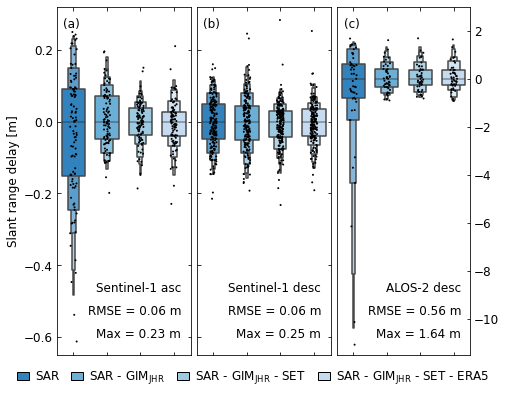

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[7, 5])
for ax, df in zip(axs, df_list):
    im = sns.boxenplot(ax=ax, data=df, k_depth='proportion', outlier_prop=0.05, showfliers=False, orient='v', palette="tab20c", width=0.7, saturation=1)
    sns.stripplot(ax=ax, data=df, orient='v', size=2, color='k')

# axis format
for ax in axs:
    ax.set_xticklabels([])
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)
for ax in axs[:2]: ax.set_ylim(-0.65, 0.32)
axs[2].set_ylim(-11.5, 3)
axs[0].set_ylabel('Slant range delay [m]')
axs[1].set_yticklabels([])
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position("right")
handles = [patches.Rectangle((0, 0), 1, 1, fc=plt.get_cmap('tab20c')(x), ec='k', lw=1) for x in [0, 1, 2, 3]]
labels = [r'SAR',
          r'SAR - GIM$_\mathrm{JHR}$',
          r'SAR - GIM$_\mathrm{JHR}$ - SET',
          r'SAR - GIM$_\mathrm{JHR}$ - SET - ERA5']
fig.tight_layout(pad=0.5)
fig.legend(handles=handles, labels=labels, ncol=4, loc='lower left', bbox_to_anchor=(0.01, -0.1), frameon=False, columnspacing=1, handlelength=1, handletextpad=0.5)

# label
ts_list = [df.iloc[:,-1:] for df in df_list]
rmse_list = [ut.root_mean_sq_error(ts) for ts in ts_list]
max_list = [np.nanmax(np.abs(ts)) for ts in ts_list]
for ax, label in zip(axs, ['(a)', '(b)', '(c)']):
    ax.annotate(label, xy=(0.17, 0.94), xycoords='axes fraction', ha='right')
labels = [
    'Sentinel-1 asc\nRMSE = {:.2f} m\nMax = {:.2f} m'.format(rmse_list[0], max_list[0]),
    'Sentinel-1 desc\nRMSE = {:.2f} m\nMax = {:.2f} m'.format(rmse_list[1], max_list[1]),
    'ALOS-2 desc\nRMSE = {:.2f} m\nMax = {:.2f} m'.format(rmse_list[2], max_list[2]),
]
for ax, label in zip(axs, labels):
    ax.annotate(label, xy=(0.93, 0.05), xycoords='axes fraction', ha='right', linespacing=2.0)

# output
out_fig = os.path.join(work_dir, 'box_stats.pdf')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Table III - Comparing different TEC products

In [10]:
dDicts = []
for proj_dir in proj_dirs:
    #proj_dir = proj_dirs[0]
    suffix = '' if 'Alos2' in proj_dir else '_S1Bias'
    fnames = [os.path.join(proj_dir, f'timeseriesRg{suffix}_SET_ERA5.h5'),
              os.path.join(proj_dir, f'timeseriesRg{suffix}_SET_ERA5_TECclr.h5'),
              os.path.join(proj_dir, f'timeseriesRg{suffix}_SET_ERA5_TECjlr.h5'),
              os.path.join(proj_dir, f'timeseriesRg{suffix}_SET_ERA5_TECjhr.h5'),
              os.path.join(proj_dir, f'timeseriesRg{suffix}_SET_ERA5_TECsub.h5')]
    proj_name, dDict = utils.read_ts_files(fnames, print_max=False)[:2]
    dDicts.append(dDict)

# Expected ALOS-2 geolocation using sub-orbital TEC
a2_jhr = ut.root_mean_sq_error(dDicts[2]['SAR - SET - ERA5 - TECjhr']) * 100.
a2_top = 46.2 # cm
a2_sub = np.sqrt(a2_jhr**2 - a2_top**2)
print('Expected ALOS-2 RMSE with sub-orbital TEC   : {:6.1f} cm'.format(a2_sub))

ChileSenAT149: RMSE
    SAR - S1Bias - SET - ERA5               :   18.1 cm
    SAR - S1Bias - SET - ERA5 - TECclr      :   21.2 cm
    SAR - S1Bias - SET - ERA5 - TECjlr      :   19.2 cm
    SAR - S1Bias - SET - ERA5 - TECjhr      :    6.4 cm
    SAR - S1Bias - SET - ERA5 - TECsub      :    4.9 cm
ChileSenDT156: RMSE
    SAR - S1Bias - SET - ERA5               :    5.7 cm
    SAR - S1Bias - SET - ERA5 - TECclr      :    5.1 cm
    SAR - S1Bias - SET - ERA5 - TECjlr      :    5.1 cm
    SAR - S1Bias - SET - ERA5 - TECjhr      :    5.6 cm
KyushuAlos2DT23: RMSE
    SAR - SET - ERA5                        :  271.2 cm
    SAR - SET - ERA5 - TECclr               :  138.1 cm
    SAR - SET - ERA5 - TECjlr               :  131.3 cm
    SAR - SET - ERA5 - TECjhr               :   55.7 cm
Expected ALOS-2 RMSE with sub-orbital TEC   :   31.1 cm


### Implication for Stack Coregistration

In [18]:
s1_ts = []
a2_ts = []
for proj_dir in proj_dirs:
    suffix = '' if 'Alos2' in proj_dir else '_S1Bias'
    fnames = [os.path.join(proj_dir, f'timeseriesRg{suffix}_TECjhr_SET_ERA5.h5')]
    proj_name, dDict = utils.read_ts_files(fnames, print_max=False)[:2]
    # save info
    if 'Sen' in proj_name:
        s1_ts += dDict['SAR - S1Bias - TECjhr - SET - ERA5'].tolist()
    else:
        a2_ts += dDict['SAR - TECjhr - SET - ERA5'].tolist()

ChileSenAT149: RMSE
    SAR - S1Bias - TECjhr - SET - ERA5      :    6.4 cm
ChileSenDT156: RMSE
    SAR - S1Bias - TECjhr - SET - ERA5      :    5.7 cm
KyushuAlos2DT23: RMSE
    SAR - TECjhr - SET - ERA5               :   55.7 cm


In [19]:
# Conclusion for stack coregistration - S1
s1_num = len(s1_ts)
s1_rg_std = np.std(s1_ts)  # Yunjun et al. [in prep]
s1_az_std = 0.36                          # Gisinger et al. (2021)
s1_rg_std_pix = s1_rg_std * 2 / sensor.SENSOR_DICT['sen']['range_pixel_size']
s1_az_std_pix = s1_az_std * 2 / sensor.SENSOR_DICT['sen']['azimuth_pixel_size']
print(f'S1 ({s1_num} images) - rg: {s1_rg_std:.2f} m (1-sigma) / {s1_rg_std_pix:.2f} pixel (2-sigma)')
print(f'S1 ({s1_num} images) - az: {s1_az_std:.2f} m (1-sigma) / {s1_az_std_pix:.2f} pixel (2-sigma)')

S1 (304 images) - rg: 0.06 m (1-sigma) / 0.05 pixel (2-sigma)
S1 (304 images) - az: 0.36 m (1-sigma) / 0.05 pixel (2-sigma)


In [21]:
# Conclusion for stack coregistration - ALOS-2
a2_num = len(a2_ts)
a2_rg_std = np.std(a2_ts)  # Yunjun et al. [in prep]
for rg_std in [a2_rg_std, a2_sub/100.]:
    rg_std_pix_a1 = rg_std / sensor.SENSOR_DICT['alos']['range_pixel_size']['stripmap_FBD']
    rg_std_pix_a2 = rg_std / sensor.SENSOR_DICT['alos2']['range_pixel_size']['stripmap_ultrafine']
    rg_std_pix_ni = rg_std / sensor.SENSOR_DICT['ni']['range_pixel_size']['24MHz']
    print(f'ALOS-2 ({a2_num} images) - rg: {rg_std:.2f} m (1-sigma)')
    print('ALOS  - rg: {:.2f} pixel (1-sigma)'.format(rg_std_pix_a1))
    print('ALOS2 - rg: {:.2f} pixel (1-sigma)'.format(rg_std_pix_a2))
    print('NISAR - rg: {:.2f} pixel (1-sigma)'.format(rg_std_pix_ni))
    print('')

ALOS-2 (49 images) - rg: 0.55 m (1-sigma)
ALOS  - rg: 0.06 pixel (1-sigma)
ALOS2 - rg: 0.38 pixel (1-sigma)
NISAR - rg: 0.09 pixel (1-sigma)

ALOS-2 (49 images) - rg: 0.05 m (1-sigma)
ALOS  - rg: 0.01 pixel (1-sigma)
ALOS2 - rg: 0.04 pixel (1-sigma)
NISAR - rg: 0.01 pixel (1-sigma)

